# Supervised Learning Models

In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('fivethirtyeight')
import seaborn as sns
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',35)

import warnings
warnings.filterwarnings('ignore')

import itertools, math, time, re, pickle

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, ShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, auc, confusion_matrix, precision_score, recall_score, roc_curve, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize, LabelBinarizer
from sklearn.svm import SVC
from xgboost import XGBClassifier


import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint
from radar_plotting import plot_radar

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

This notebook uses the data/labels created from the unsupervised learning notebook.

## Pre-Modeling Prep

In [2]:
df = pd.read_csv('results2/kmeans_results.csv')

In [3]:
df.head()

,Player,GP,MIN,PTS,FG%,3PA,3P%,REB,AST,TO,STL,BLK,Close FGA,Close FG%,Mid FGA,Mid FG%,Post_Ups,Drives,Height,Pos,TEAM,Class
0,Aaron Gordon: 2015,78.0,23.9,9.2,47.3,1.8,29.6,6.5,1.6,0.8,0.8,0.7,4.3,60.5,1.3,31.7,0.6,2.2,81.0,PF,ORL,2
1,Al Horford: 2015,82.0,32.1,15.2,50.5,3.1,34.4,7.3,3.2,1.3,0.8,1.5,5.6,64.3,4.1,44.4,3.8,2.1,82.0,C,ATL,2
2,Al Jefferson: 2015,47.0,23.3,12.0,48.5,0.0,0.0,6.4,1.5,0.7,0.6,0.9,6.8,51.5,4.0,43.9,11.3,0.0,82.0,C,CHA,3
3,Andre Drummond: 2015,81.0,32.9,16.2,52.1,0.1,33.3,14.8,0.8,1.9,1.5,1.4,12.2,54.1,0.8,25.0,6.0,0.9,83.0,C,DET,5
4,Andrew Bogut: 2015,70.0,20.7,5.4,62.7,0.0,100.0,7.0,2.3,1.2,0.5,1.6,3.8,65.8,0.1,30.0,2.5,0.1,84.0,C,GSW,2


**Classes:**

- 0: Ball-Dominant Scorer - "Best" player on a team, main contributor in anything offensive related
- 1: Role Player - Contributes but does not excel in any area
- 2: Stretch Big - Shoots more 3PT and drives in more than a traditional big in exchange for less rebounds
- 3: Traditional Big - Rebounds and blocks shots well, rarely shoots and almost exclusively takes shots inside
- 4: Secondary Guard - Drives and assists with above average 3PT shooting, shortest average height
- 5: High-Usage Big - Scores a lot, rebounds well, takes a lot of shots inside the paint at a high percentage

In [4]:
df['Class'].value_counts()

1    408
4    334
2    232
0    178
3    128
5    103
Name: Class, dtype: int64

In [5]:
df['Class'].value_counts() / df['Class'].shape[0]

1    0.295011
4    0.241504
2    0.167751
0    0.128706
3    0.092552
5    0.074476
Name: Class, dtype: float64

**Takeaways:**

- Around 30% of the players are classified as *Role Players*.
- *High-Usage Bigs* and *Traditional Bigs* each make up less than 10%, which makes sense because big men, themselves, are broken up into 3 different categories. 
- The most common non-Role Player is the *Secondary Guard* at almost 25%
- *Stretch Bigs* are the highest out of the big men categorizations at 16.8%, which makes sense considering the current era where more players are asked to shoot from distance.

## Model Functions & Metrics

**Build Model Function**

In [6]:
def build_model(model, X_train, X_test, y_train, y_test, decision_function=True, n_classes=11):
    start = time.time()
    
    # make sure to uncomment the next line for logistic regression
    #clf = OneVsRestClassifier(model)
    
    # comment this next line for logistic regression
    clf = model
    clf.fit(X_train,y_train)  
    y_hat_test = clf.predict(X_test)
      
    if decision_function==True:
        y_score = clf.decision_function(X_test)
    else:
        y_score = clf.predict_proba(X_test)[:, 1]
        
    print('Total Runtime: {} seconds'.format(time.time()-start))
    
    return clf, y_hat_test, y_score

**Plot Feature Importances** 

In [7]:
def plot_feature_importances(model):
    n_features = len(X.columns)
    plt.figure(figsize=(14,10))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Features")
    plt.tight_layout()
    #plt.savefig('figures/semisupervised/phase_1_features')

**Plot Confusion Matrix**

In [8]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    #Create the basic matrix.
    plt.figure(figsize=(10,10))
    plt.imshow(cm, cmap)
    
    #Add title and Axis Labels
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    #Add appropriate Axis Scales
    class_names = ['1','2', '3', '4', '5', '6']
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    
    #Add Labels to Each Cell
    thresh = cm.max()*.75
    
    #Add a Side Bar Legend Showing Colors
    plt.colorbar()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    #plt.savefig('figures/semisupervised/phase2_confusion')

**Plot Metrics**

In [9]:
def print_model_metrics(y_pred,y_score,y_test):
    cm = confusion_matrix(y_test, y_pred)
    #print(cm)

    plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues)

    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred, average='micro')
    recall = recall_score(y_test,y_pred, average='micro')
    f1 = f1_score(y_test,y_pred, average='micro')
    
    #print('Training Set Metrics:')
    print('Accuracy: {}\n'.format(round(accuracy,4)))
    print('Micro Precision: {}'.format(round(precision,4)))
    print('Micro Recall: {}'.format(round(recall,4)))
    print('Micro F1: {}\n'.format(round(f1,4)))

    print('Macro Precision: {:.4f}'.format(precision_score(y_test, y_pred, average='macro')))
    print('Macro Recall: {:.4f}'.format(recall_score(y_test, y_pred, average='macro')))
    print('Macro F1-score: {:.4f}\n'.format(f1_score(y_test, y_pred, average='macro')))

    print('Weighted Precision: {:.4f}'.format(precision_score(y_test, y_pred, average='weighted')))
    print('Weighted Recall: {:.4f}'.format(recall_score(y_test, y_pred, average='weighted')))
    print('Weighted F1-score: {:.4f}'.format(f1_score(y_test, y_pred, average='weighted')))

## Categorical Variables

In [15]:
X = df.drop(['Player', 'GP', 'Class', 'TEAM'], axis=1)
y = df['Class']

In [16]:
# get dummy variables for position
X = pd.get_dummies(X, drop_first=True)
X.head()

,MIN,PTS,FG%,3PA,3P%,REB,AST,TO,STL,BLK,Close FGA,Close FG%,Mid FGA,Mid FG%,Post_Ups,Drives,Height,Pos_PF,Pos_PG,Pos_SF,Pos_SG
0,23.9,9.2,47.3,1.8,29.6,6.5,1.6,0.8,0.8,0.7,4.3,60.5,1.3,31.7,0.6,2.2,81.0,1,0,0,0
1,32.1,15.2,50.5,3.1,34.4,7.3,3.2,1.3,0.8,1.5,5.6,64.3,4.1,44.4,3.8,2.1,82.0,0,0,0,0
2,23.3,12.0,48.5,0.0,0.0,6.4,1.5,0.7,0.6,0.9,6.8,51.5,4.0,43.9,11.3,0.0,82.0,0,0,0,0
3,32.9,16.2,52.1,0.1,33.3,14.8,0.8,1.9,1.5,1.4,12.2,54.1,0.8,25.0,6.0,0.9,83.0,0,0,0,0
4,20.7,5.4,62.7,0.0,100.0,7.0,2.3,1.2,0.5,1.6,3.8,65.8,0.1,30.0,2.5,0.1,84.0,0,0,0,0


## Train Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)

In [18]:
y_train

654     4
318     4
1088    4
153     5
808     0
       ..
1337    5
406     1
143     2
1265    1
623     1
Name: Class, Length: 1037, dtype: int64

In [19]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

## Scale Data
Scaling is done after the train test split in order to ensure that the training set is not influenced at all by the test set.

In [20]:
# scale using MinMaxScaler
mm = MinMaxScaler()
X_train_scaled = mm.fit_transform(X_train)
X_test_scaled = mm.fit_transform(X_test)

# convert back into DataFrame to preserve column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

In [21]:
X_train_scaled.head()

,MIN,PTS,FG%,3PA,3P%,REB,AST,TO,STL,BLK,Close FGA,Close FG%,Mid FGA,Mid FG%,Post_Ups,Drives,Height,Pos_PF,Pos_PG,Pos_SF,Pos_SG
0,0.368715,0.156051,0.243750,0.153226,0.376,0.253425,0.557522,0.388889,0.565217,0.054054,0.251799,0.352720,0.233333,0.299,0.014388,0.333333,0.222222,0.0,1.0,0.0,0.0
1,0.664804,0.665605,0.308333,0.830645,0.425,0.164384,0.345133,0.148148,0.434783,0.081081,0.338129,0.287054,0.388889,0.460,0.000000,0.289683,0.333333,0.0,0.0,0.0,1.0
2,0.452514,0.423567,0.312500,0.459677,0.367,0.123288,0.415929,0.388889,0.260870,0.054054,0.302158,0.454034,0.188889,0.420,0.021583,0.428571,0.333333,0.0,1.0,0.0,0.0
3,0.525140,0.433121,0.383333,0.290323,0.314,0.534247,0.265487,0.296296,0.391304,0.297297,0.496403,0.512195,0.411111,0.431,0.438849,0.099206,0.833333,0.0,0.0,0.0,0.0
4,0.709497,0.627389,0.300000,0.532258,0.359,0.075342,0.433628,0.500000,0.434783,0.054054,0.460432,0.375235,0.377778,0.442,0.000000,0.456349,0.222222,0.0,0.0,0.0,1.0


# Modeling

## Random Forest

In [17]:
# tried scaled data as well, but better results achieved with non-scaled data
rf, rf_y_preds, rf_y_score = build_model(RandomForestClassifier(),
                                                         X_train, X_test,
                                                         y_train, y_test,
                                                        decision_function=False)

Total Runtime: 0.2958650588989258 seconds


Accuracy: 0.9104

Micro Precision: 0.9104
Micro Recall: 0.9104
Micro F1: 0.9104

Macro Precision: 0.9062
Macro Recall: 0.9094
Macro F1-score: 0.9076

Weighted Precision: 0.9111
Weighted Recall: 0.9104
Weighted F1-score: 0.9104


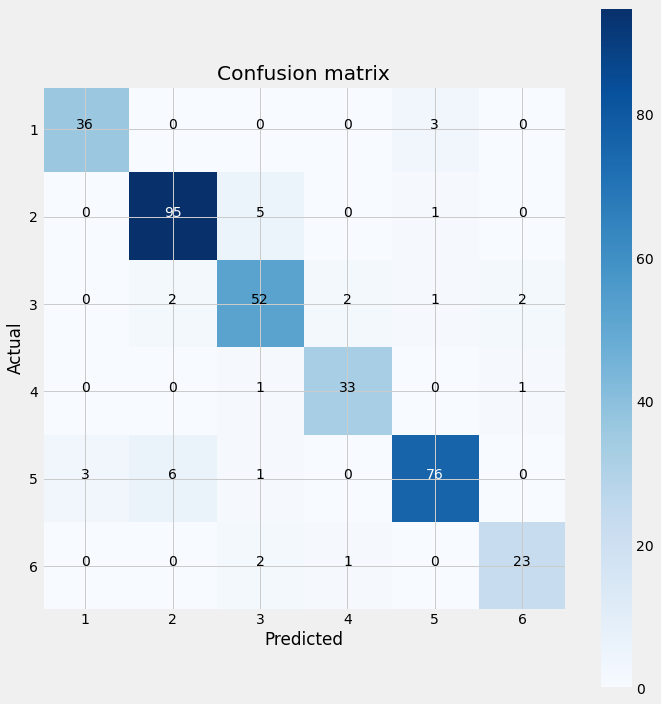

In [18]:
print_model_metrics(rf_y_preds, rf_y_score, y_test)

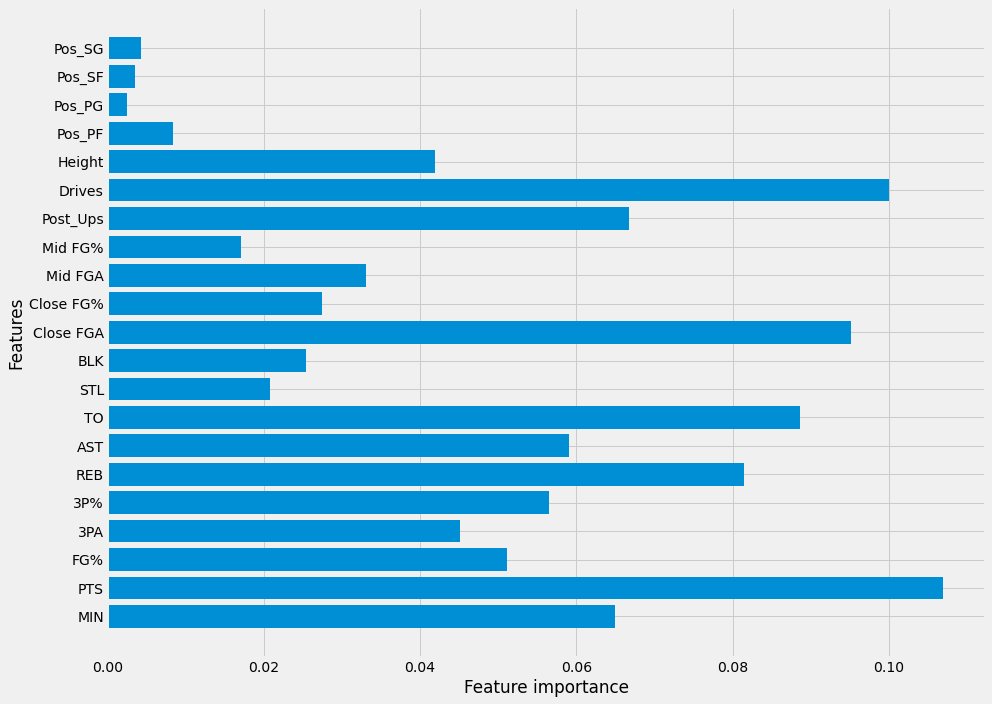

In [19]:
plot_feature_importances(rf)

**Gridsearch**

In [20]:
rf_param_grid = {"n_estimators": [100, 200, 300],
                  "min_samples_leaf": [3, 5],
                  "min_samples_split": [5,10,15],
                  "criterion": ["gini", "entropy"]
                }

In [21]:
rf_gs, rf_gs_y_preds, rf_gs_y_score = build_model(GridSearchCV(rf, param_grid=rf_param_grid),
                                                         X_train, X_test,
                                                         y_train, y_test,
                                                        decision_function=False)

Total Runtime: 70.18057656288147 seconds


Accuracy: 0.9133

Micro Precision: 0.9133
Micro Recall: 0.9133
Micro F1: 0.9133

Macro Precision: 0.9146
Macro Recall: 0.9072
Macro F1-score: 0.9096

Weighted Precision: 0.9140
Weighted Recall: 0.9133
Weighted F1-score: 0.9130


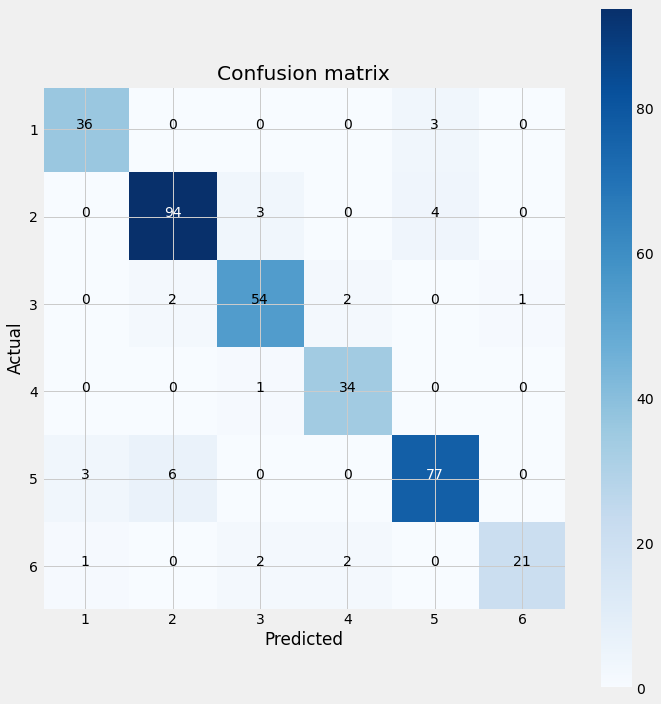

In [22]:
print_model_metrics(rf_gs_y_preds, rf_gs_y_score, y_test)

In [23]:
rf_gs.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 200}

In [24]:
rf_gs.best_score_

0.8948764399851357

In [25]:
print(f'Training Accuracy: {rf_gs.score(X_train, y_train)}')
print(f'Test Accuracy: {rf_gs.score(X_test, y_test)}')

Training Accuracy: 1.0
Test Accuracy: 0.9132947976878613


## Gradient Boost

In [26]:
gb, gb_y_preds, gb_y_score = build_model(GradientBoostingClassifier(),
                                         X_train, X_test, y_train, y_test)

Total Runtime: 1.9094922542572021 seconds


Accuracy: 0.896

Micro Precision: 0.896
Micro Recall: 0.896
Micro F1: 0.896

Macro Precision: 0.8887
Macro Recall: 0.8853
Macro F1-score: 0.8861

Weighted Precision: 0.8957
Weighted Recall: 0.8960
Weighted F1-score: 0.8954


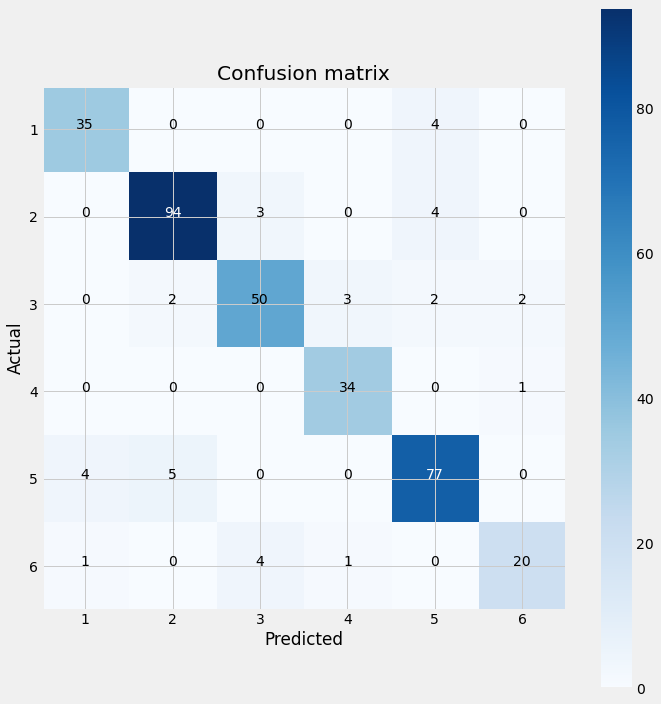

In [27]:
print_model_metrics(gb_y_preds, gb_y_score, y_test)

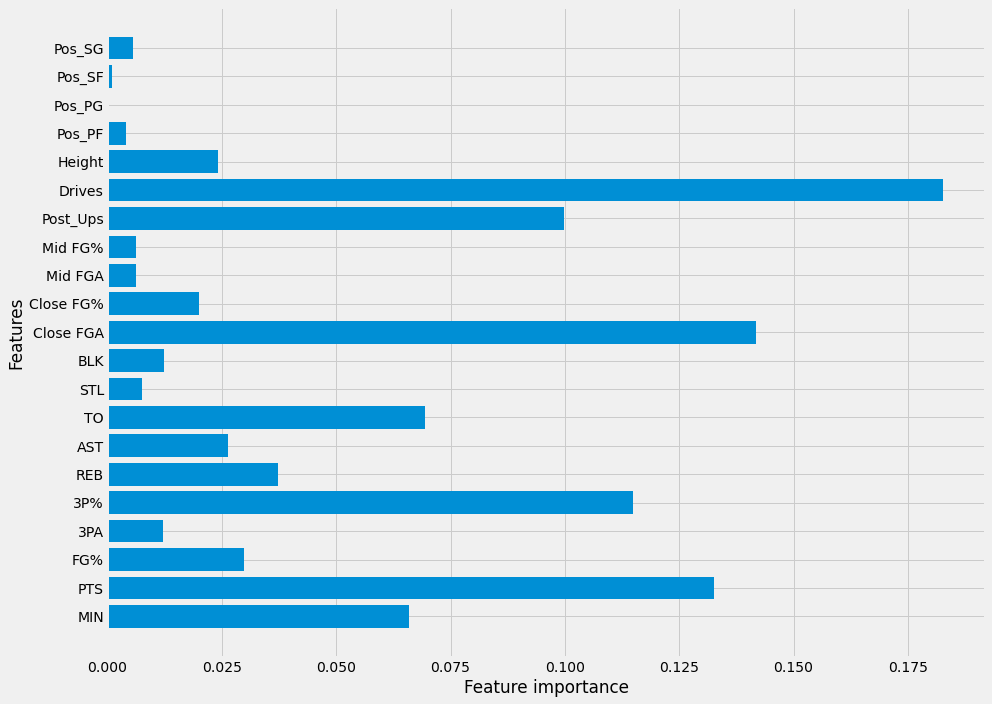

In [28]:
plot_feature_importances(gb)

**Gridsearch**

In [29]:
gb_param_grid = {"n_estimators": [50, 100, 250],
                  "learning_rate": [.005, .01, .1]
                }

gb_gs, gb_gs_y_preds, gb_gs_y_score = build_model(GridSearchCV(gb, param_grid=gb_param_grid),
                                                         X_train, X_test,
                                                         y_train, y_test,
                                                        decision_function=False)

Total Runtime: 88.21212100982666 seconds


Accuracy: 0.896

Micro Precision: 0.896
Micro Recall: 0.896
Micro F1: 0.896

Macro Precision: 0.8913
Macro Recall: 0.8933
Macro F1-score: 0.8919

Weighted Precision: 0.8964
Weighted Recall: 0.8960
Weighted F1-score: 0.8959


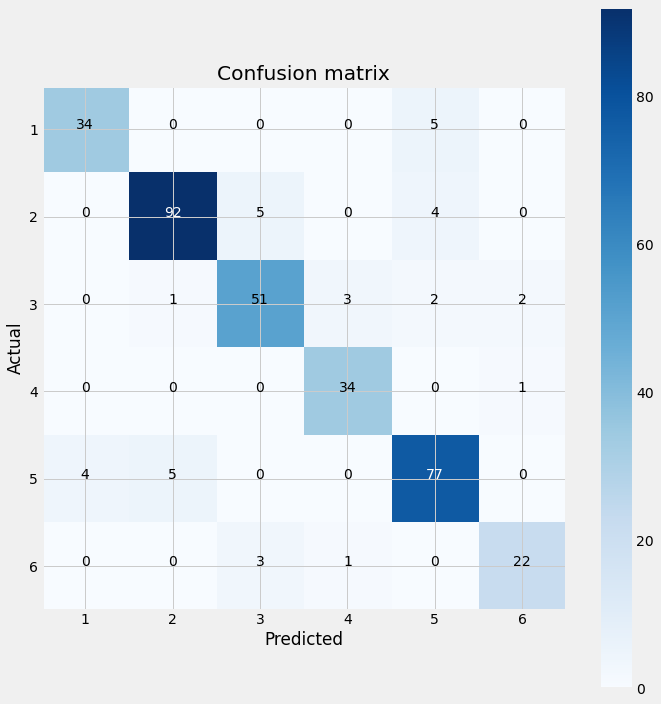

In [30]:
print_model_metrics(gb_gs_y_preds, gb_gs_y_score, y_test)

In [31]:
print(gb_gs.best_params_)

print(f'Training Accuracy: {gb_gs.score(X_train, y_train)}')
print(f'Test Accuracy: {gb_gs.score(X_test, y_test)}')

{'learning_rate': 0.1, 'n_estimators': 250}
Training Accuracy: 1.0
Test Accuracy: 0.8959537572254336


## AdaBoost

In [26]:
ada, ada_y_preds, ada_y_score = build_model(AdaBoostClassifier(algorithm="SAMME",
                                                              learning_rate=.05),
                                            X_train, X_test, y_train, y_test)

Total Runtime: 0.12432599067687988 seconds


Accuracy: 0.448

Micro Precision: 0.448
Micro Recall: 0.448
Micro F1: 0.448

Macro Precision: 0.2959
Macro Recall: 0.2810
Macro F1-score: 0.2241

Weighted Precision: 0.3949
Weighted Recall: 0.4480
Weighted F1-score: 0.3437


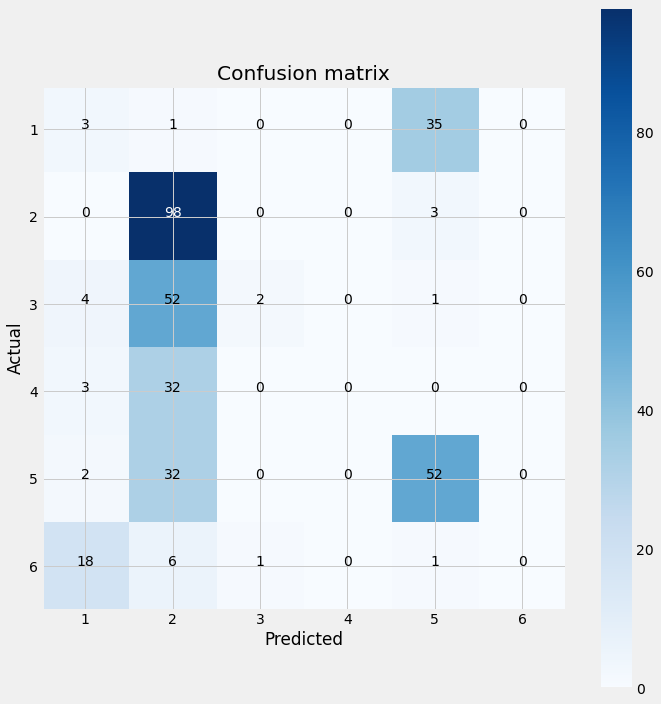

In [27]:
print_model_metrics(ada_y_preds, ada_y_score, y_test)

## XGBoost

In [17]:
xgb, xgb_y_preds, xgb_y_score = build_model(XGBClassifier(objective='multi:softmax'), 
                                            X_train, X_test, y_train, y_test, decision_function=False)

Total Runtime: 0.43471384048461914 seconds


Accuracy: 0.8873

Micro Precision: 0.8873
Micro Recall: 0.8873
Micro F1: 0.8873

Macro Precision: 0.8814
Macro Recall: 0.8895
Macro F1-score: 0.8845

Weighted Precision: 0.8881
Weighted Recall: 0.8873
Weighted F1-score: 0.8871


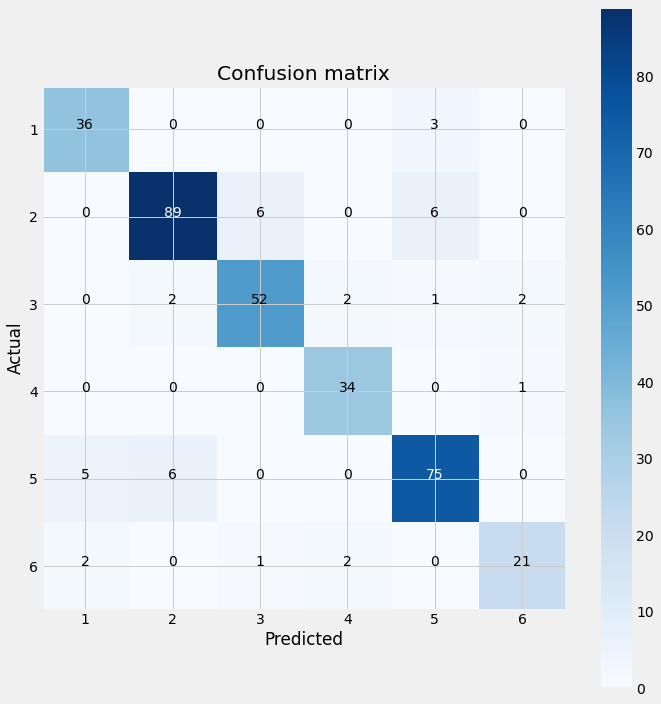

In [18]:
print_model_metrics(xgb_y_preds, xgb_y_score, y_test)

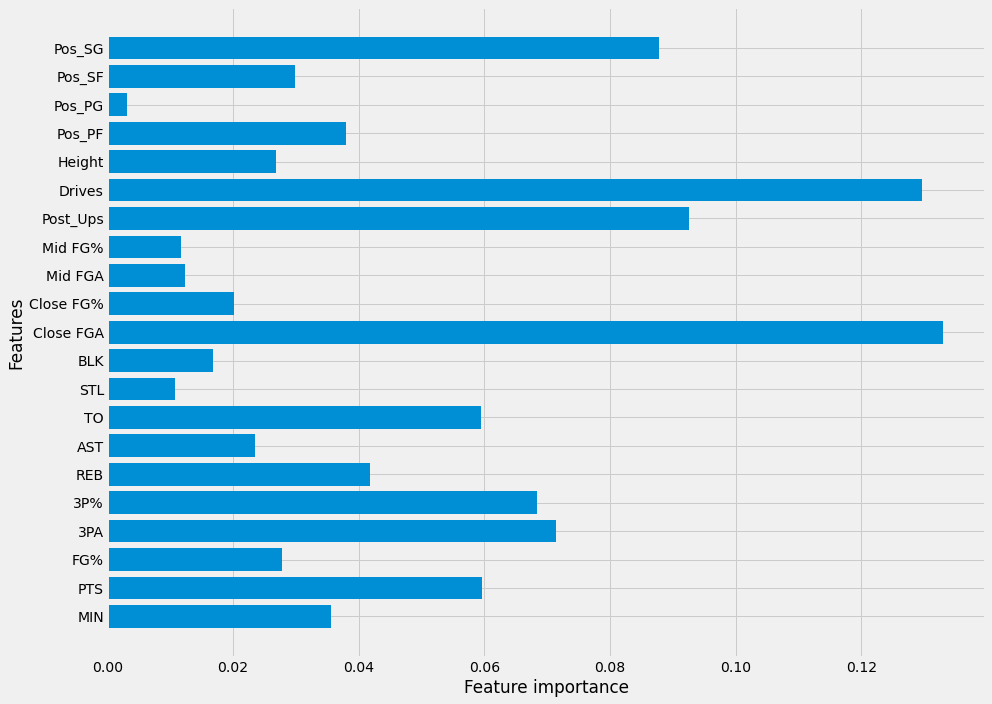

In [19]:
plot_feature_importances(xgb)

In [20]:
%reset_selective -f xgb_gs

In [21]:
xgb_param_grid = {"min_child_weight": [1, 2],
                  "max_depth": [4, 6, 7],
                  "learning_rate": [.001, .01, .1]
                }

xgb_gs, xgb_gs_y_preds, xgb_gs_y_score = build_model(GridSearchCV(xgb, param_grid=xgb_param_grid),
                                                         X_train, X_test,
                                                         y_train, y_test,
                                                        decision_function=False)

Total Runtime: 27.010681867599487 seconds


Accuracy: 0.8757

Micro Precision: 0.8757
Micro Recall: 0.8757
Micro F1: 0.8757

Macro Precision: 0.8626
Macro Recall: 0.8727
Macro F1-score: 0.8670

Weighted Precision: 0.8766
Weighted Recall: 0.8757
Weighted F1-score: 0.8757


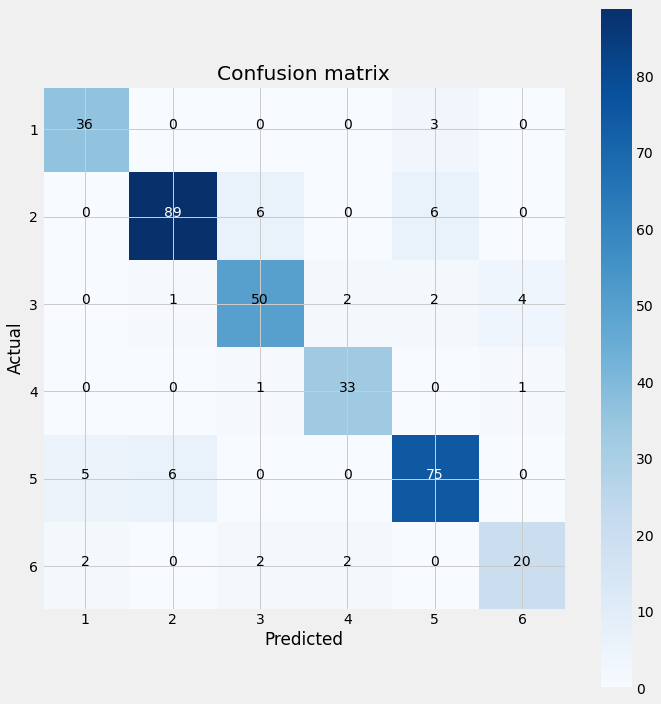

In [22]:
print_model_metrics(xgb_gs_y_preds, xgb_gs_y_score, y_test)

In [23]:
xgb_gs.best_params_

{'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1}

Try manually tuning as well.

In [17]:
%reset_selective -f xgb_man

In [18]:
xgb_man, xgb_man_y_preds, xgb_man_y_score = build_model(XGBClassifier(objective='multi:softmax',
                                                                     learning_rate=.2,
                                                                     n_estimators=1000,
                                                                     max_depth=3,
                                                                     colsample_bytree=.2,
                                                                     gamma=3,
                                                                     min_child_weight=2), 
                                            X_train, X_test, y_train, y_test, decision_function=False)

Total Runtime: 1.6201691627502441 seconds


Accuracy: 0.922

Micro Precision: 0.922
Micro Recall: 0.922
Micro F1: 0.922

Macro Precision: 0.9176
Macro Recall: 0.9281
Macro F1-score: 0.9222

Weighted Precision: 0.9226
Weighted Recall: 0.9220
Weighted F1-score: 0.9218


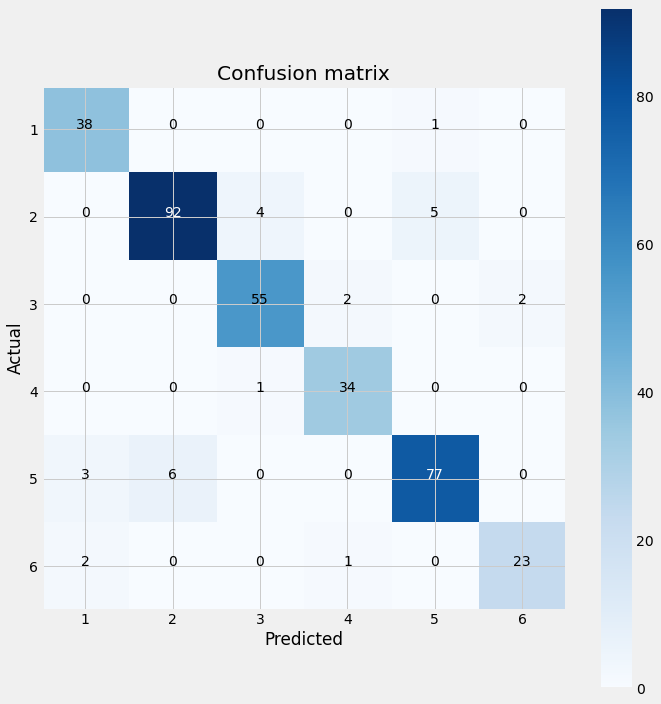

In [19]:
print_model_metrics(xgb_man_y_preds, xgb_man_y_score, y_test)

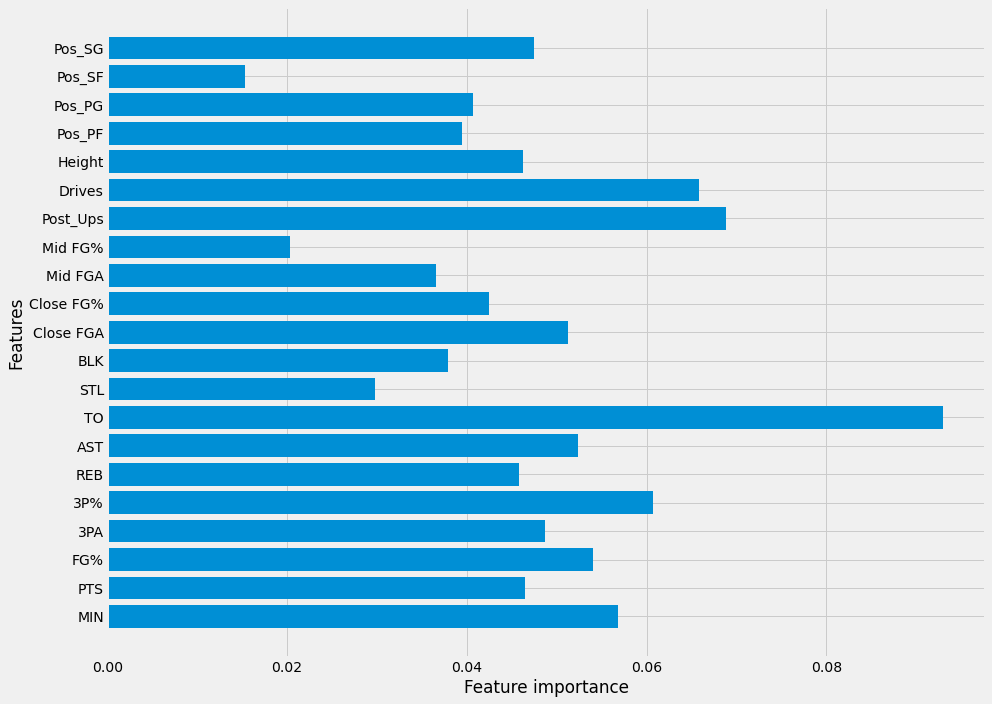

In [20]:
plot_feature_importances(xgb_man)

In [21]:
print(f'Training Accuracy: {xgb_man.score(X_train, y_train)}')
print(f'Test Accuracy: {xgb_man.score(X_test, y_test)}')

Training Accuracy: 0.9749276759884281
Test Accuracy: 0.9219653179190751


## SVM: Support Vector Machine

In [27]:
%reset_selective -f svm

In [30]:
svm, svm_y_preds, svm_y_score = build_model(SVC(kernel='poly', degree=11,decision_function_shape='ovo'), 
                                            X_train, X_test, y_train, y_test)

Total Runtime: 0.01358485221862793 seconds


Accuracy: 0.5909

Micro Precision: 0.5909
Micro Recall: 0.5909
Micro F1: 0.5909

Macro Precision: 0.5480
Macro Recall: 0.5508
Macro F1-score: 0.5404

Weighted Precision: 0.5993
Weighted Recall: 0.5909
Weighted F1-score: 0.5873


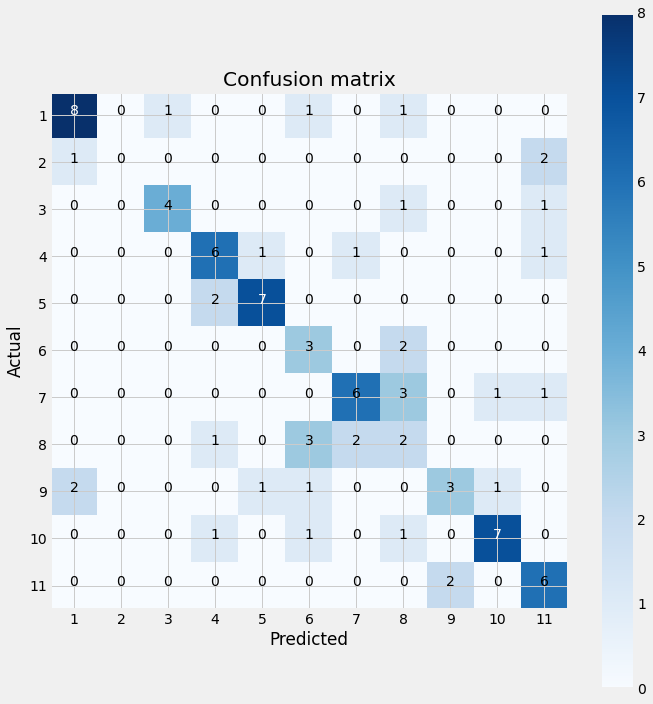

In [31]:
print_model_metrics(svm_y_preds, svm_y_score, y_test)

## Neural Network

In [22]:
# binarize target column

binarizer = LabelBinarizer()
labels = binarizer.fit_transform(y_train)

In [34]:
%reset_selective -f model_1

In [25]:
model_1 = Sequential()
model_1.add(Dense(64, activation='tanh', input_shape=(21,)))
model_1.add(Dense(32, activation='tanh'))
model_1.add(Dense(6, activation='softmax'))

model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [26]:
model_1_results = model_1.fit(X_train_scaled, labels, epochs=150, batch_size=32, validation_split=0.2)

Epoch 1/150
26/26 [==============================] - 0s 6ms/step - loss: 1.5866 - acc: 0.3655 - val_loss: 1.4765 - val_acc: 0.3990
Epoch 2/150
26/26 [==============================] - 0s 1ms/step - loss: 1.2976 - acc: 0.5259 - val_loss: 1.2081 - val_acc: 0.6154
Epoch 3/150
26/26 [==============================] - 0s 1ms/step - loss: 1.0609 - acc: 0.6562 - val_loss: 0.9975 - val_acc: 0.6779
Epoch 4/150
26/26 [==============================] - 0s 1ms/step - loss: 0.8582 - acc: 0.7793 - val_loss: 0.8512 - val_acc: 0.7260
Epoch 5/150
26/26 [==============================] - 0s 1ms/step - loss: 0.7156 - acc: 0.8118 - val_loss: 0.7268 - val_acc: 0.7837
Epoch 6/150
26/26 [==============================] - 0s 1ms/step - loss: 0.6121 - acc: 0.8468 - val_loss: 0.6666 - val_acc: 0.7981
Epoch 7/150
26/26 [==============================] - 0s 1ms/step - loss: 0.5373 - acc: 0.8721 - val_loss: 0.6054 - val_acc: 0.8029
Epoch 8/150
26/26 [==============================] - 0s 1ms/step - loss: 0.4826 - a

Epoch 63/150
26/26 [==============================] - 0s 1ms/step - loss: 0.1054 - acc: 0.9686 - val_loss: 0.2198 - val_acc: 0.9279
Epoch 64/150
26/26 [==============================] - 0s 1ms/step - loss: 0.0995 - acc: 0.9759 - val_loss: 0.2305 - val_acc: 0.9087
Epoch 65/150
26/26 [==============================] - 0s 1ms/step - loss: 0.1014 - acc: 0.9759 - val_loss: 0.2164 - val_acc: 0.9135
Epoch 66/150
26/26 [==============================] - 0s 1ms/step - loss: 0.0948 - acc: 0.9807 - val_loss: 0.2117 - val_acc: 0.9135
Epoch 67/150
26/26 [==============================] - 0s 1ms/step - loss: 0.0941 - acc: 0.9807 - val_loss: 0.2151 - val_acc: 0.9135
Epoch 68/150
26/26 [==============================] - 0s 1ms/step - loss: 0.0928 - acc: 0.9783 - val_loss: 0.2193 - val_acc: 0.9135
Epoch 69/150
26/26 [==============================] - 0s 1ms/step - loss: 0.0945 - acc: 0.9735 - val_loss: 0.2243 - val_acc: 0.9135
Epoch 70/150
26/26 [==============================] - 0s 1ms/step - loss: 0.

Epoch 125/150
26/26 [==============================] - 0s 1ms/step - loss: 0.0463 - acc: 0.9928 - val_loss: 0.2147 - val_acc: 0.9135
Epoch 126/150
26/26 [==============================] - 0s 1ms/step - loss: 0.0483 - acc: 0.9928 - val_loss: 0.2105 - val_acc: 0.9231
Epoch 127/150
26/26 [==============================] - 0s 1ms/step - loss: 0.0509 - acc: 0.9879 - val_loss: 0.2050 - val_acc: 0.9327
Epoch 128/150
26/26 [==============================] - 0s 1ms/step - loss: 0.0460 - acc: 0.9891 - val_loss: 0.1956 - val_acc: 0.9279
Epoch 129/150
26/26 [==============================] - 0s 1ms/step - loss: 0.0445 - acc: 0.9928 - val_loss: 0.1933 - val_acc: 0.9231
Epoch 130/150
26/26 [==============================] - 0s 1ms/step - loss: 0.0477 - acc: 0.9916 - val_loss: 0.1997 - val_acc: 0.9279
Epoch 131/150
26/26 [==============================] - 0s 1ms/step - loss: 0.0488 - acc: 0.9903 - val_loss: 0.2190 - val_acc: 0.9279
Epoch 132/150
26/26 [==============================] - 0s 1ms/step - 

Model looks a little overfit. The goal further is to address the overfit model and to minimize loss.

In [42]:
%reset_selective -f model_2

In [43]:
model_2 = Sequential()
#model_2.add(Dense(128, activation='tanh', input_shape=(1037,29)))
model_2.add(Dense(128, activation='tanh', input_shape=(21,)))
model_2.add(Dense(32, activation='tanh'))
model_2.add(Dropout(.2))
model_2.add(Dense(6, activation='softmax'))

model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [44]:
checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',
                             save_best_only=True, mode='auto')
model_2_results = model_2.fit(X_train_scaled, labels, epochs=150, batch_size=32, 
                              validation_split=0.2, callbacks=[checkpoint])

Epoch 1/150
 1/26 [>.............................] - ETA: 0s - loss: 1.7541 - acc: 0.2188
Epoch 00001: val_loss improved from inf to 1.40161, saving model to model-001-0.318456-0.375000.h5
26/26 [==============================] - 0s 6ms/step - loss: 1.5706 - acc: 0.3185 - val_loss: 1.4016 - val_acc: 0.3750
Epoch 2/150
 1/26 [>.............................] - ETA: 0s - loss: 1.3580 - acc: 0.4375
Epoch 00002: val_loss improved from 1.40161 to 1.13910, saving model to model-002-0.515078-0.552885.h5
26/26 [==============================] - 0s 2ms/step - loss: 1.2360 - acc: 0.5151 - val_loss: 1.1391 - val_acc: 0.5529
Epoch 3/150
 1/26 [>.............................] - ETA: 0s - loss: 1.1837 - acc: 0.5625
Epoch 00003: val_loss improved from 1.13910 to 0.93999, saving model to model-003-0.612786-0.673077.h5
26/26 [==============================] - 0s 2ms/step - loss: 1.0262 - acc: 0.6128 - val_loss: 0.9400 - val_acc: 0.6731
Epoch 4/150
 1/26 [>.............................] - ETA: 0s - loss:

Epoch 28/150
 1/26 [>.............................] - ETA: 0s - loss: 0.1144 - acc: 1.0000
Epoch 00028: val_loss improved from 0.26319 to 0.26152, saving model to model-028-0.921592-0.927885.h5
26/26 [==============================] - 0s 2ms/step - loss: 0.2146 - acc: 0.9216 - val_loss: 0.2615 - val_acc: 0.9279
Epoch 29/150
 1/26 [>.............................] - ETA: 0s - loss: 0.1759 - acc: 0.9688
Epoch 00029: val_loss did not improve from 0.26152
26/26 [==============================] - 0s 1ms/step - loss: 0.2152 - acc: 0.9168 - val_loss: 0.2712 - val_acc: 0.8750
Epoch 30/150
 1/26 [>.............................] - ETA: 0s - loss: 0.1783 - acc: 0.9375
Epoch 00030: val_loss improved from 0.26152 to 0.25456, saving model to model-030-0.934861-0.918269.h5
26/26 [==============================] - 0s 2ms/step - loss: 0.1989 - acc: 0.9349 - val_loss: 0.2546 - val_acc: 0.9183
Epoch 31/150
 1/26 [>.............................] - ETA: 0s - loss: 0.1879 - acc: 1.0000
Epoch 00031: val_loss 

Epoch 58/150
 1/26 [>.............................] - ETA: 0s - loss: 0.0586 - acc: 1.0000
Epoch 00058: val_loss did not improve from 0.19673
26/26 [==============================] - 0s 1ms/step - loss: 0.1206 - acc: 0.9566 - val_loss: 0.2049 - val_acc: 0.9231
Epoch 59/150
 1/26 [>.............................] - ETA: 0s - loss: 0.0661 - acc: 1.0000
Epoch 00059: val_loss improved from 0.19673 to 0.19299, saving model to model-059-0.952955-0.927885.h5
26/26 [==============================] - 0s 2ms/step - loss: 0.1236 - acc: 0.9530 - val_loss: 0.1930 - val_acc: 0.9279
Epoch 60/150
 1/26 [>.............................] - ETA: 0s - loss: 0.1073 - acc: 0.9688
Epoch 00060: val_loss did not improve from 0.19299
26/26 [==============================] - 0s 1ms/step - loss: 0.1246 - acc: 0.9590 - val_loss: 0.2093 - val_acc: 0.9327
Epoch 61/150
 1/26 [>.............................] - ETA: 0s - loss: 0.1165 - acc: 0.9688
Epoch 00061: val_loss did not improve from 0.19299
26/26 [================

Epoch 89/150
 1/26 [>.............................] - ETA: 0s - loss: 0.0251 - acc: 1.0000
Epoch 00089: val_loss did not improve from 0.18930
26/26 [==============================] - 0s 1ms/step - loss: 0.0836 - acc: 0.9686 - val_loss: 0.1959 - val_acc: 0.9423
Epoch 90/150
 1/26 [>.............................] - ETA: 0s - loss: 0.0785 - acc: 0.9688
Epoch 00090: val_loss did not improve from 0.18930
26/26 [==============================] - 0s 1ms/step - loss: 0.0924 - acc: 0.9638 - val_loss: 0.2593 - val_acc: 0.8750
Epoch 91/150
 1/26 [>.............................] - ETA: 0s - loss: 0.2249 - acc: 0.9375
Epoch 00091: val_loss did not improve from 0.18930
26/26 [==============================] - 0s 1ms/step - loss: 0.1068 - acc: 0.9590 - val_loss: 0.1988 - val_acc: 0.9231
Epoch 92/150
 1/26 [>.............................] - ETA: 0s - loss: 0.0320 - acc: 1.0000
Epoch 00092: val_loss did not improve from 0.18930
26/26 [==============================] - 0s 1ms/step - loss: 0.0788 - acc: 

Epoch 120/150
 1/26 [>.............................] - ETA: 0s - loss: 0.0228 - acc: 1.0000
Epoch 00120: val_loss did not improve from 0.17569
26/26 [==============================] - 0s 1ms/step - loss: 0.0667 - acc: 0.9759 - val_loss: 0.1881 - val_acc: 0.9423
Epoch 121/150
 1/26 [>.............................] - ETA: 0s - loss: 0.1214 - acc: 0.9375
Epoch 00121: val_loss did not improve from 0.17569
26/26 [==============================] - 0s 1ms/step - loss: 0.0657 - acc: 0.9783 - val_loss: 0.1934 - val_acc: 0.9375
Epoch 122/150
 1/26 [>.............................] - ETA: 0s - loss: 0.0596 - acc: 0.9688
Epoch 00122: val_loss did not improve from 0.17569
26/26 [==============================] - 0s 1ms/step - loss: 0.0637 - acc: 0.9831 - val_loss: 0.2011 - val_acc: 0.9183
Epoch 123/150
 1/26 [>.............................] - ETA: 0s - loss: 0.1780 - acc: 0.8750
Epoch 00123: val_loss did not improve from 0.17569
26/26 [==============================] - 0s 1ms/step - loss: 0.0749 - a

The best model gave us training accuracy of .973 and test accuracy of .942

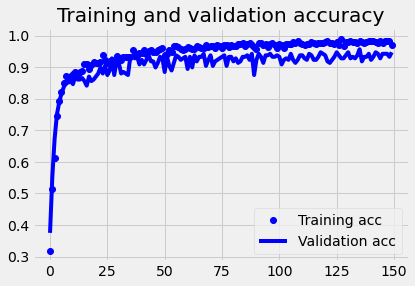

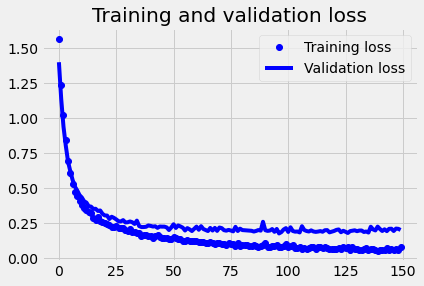

In [45]:
acc = model_2_results.history['acc']
val_acc = model_2_results.history['val_acc']
loss = model_2_results.history['loss']
val_loss = model_2_results.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [66]:
%reset_selective -f model_3

In [46]:
model_3 = Sequential()
#model_3.add(Dense(128, activation='tanh', input_shape=(1037,29)))
model_3.add(Dense(64, activation='tanh', input_shape=(21,)))
model_3.add(Dense(32, activation='tanh'))
model_3.add(Dropout(.2))
model_3.add(Dense(6, activation='softmax'))

model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [48]:
model_3_results = model_3.fit(X_train_scaled, labels, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
26/26 [==============================] - 0s 5ms/step - loss: 1.7563 - acc: 0.2738 - val_loss: 1.6083 - val_acc: 0.3750
Epoch 2/100
26/26 [==============================] - 0s 1ms/step - loss: 1.4927 - acc: 0.3860 - val_loss: 1.4067 - val_acc: 0.4760
Epoch 3/100
26/26 [==============================] - 0s 2ms/step - loss: 1.2862 - acc: 0.5127 - val_loss: 1.1918 - val_acc: 0.6202
Epoch 4/100
26/26 [==============================] - 0s 2ms/step - loss: 1.0894 - acc: 0.6273 - val_loss: 1.0213 - val_acc: 0.6827
Epoch 5/100
26/26 [==============================] - 0s 2ms/step - loss: 0.9359 - acc: 0.6743 - val_loss: 0.8717 - val_acc: 0.7260
Epoch 6/100
26/26 [==============================] - 0s 2ms/step - loss: 0.7927 - acc: 0.7455 - val_loss: 0.7601 - val_acc: 0.7548
Epoch 7/100
26/26 [==============================] - 0s 2ms/step - loss: 0.6879 - acc: 0.7949 - val_loss: 0.6742 - val_acc: 0.8077
Epoch 8/100
26/26 [==============================] - 0s 2ms/step - loss: 0.6120 - a

## Multi-Class Neural Network with Cross Validation

In [2]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(64, activation='tanh', input_shape=(21,)))
    model.add(Dense(32, activation='tanh'))
    model.add(Dropout(.2))
    model.add(Dense(11, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [31]:
from keras.wrappers.scikit_learn import KerasClassifier

estimator = KerasClassifier(build_fn=baseline_model, epochs=150, batch_size=32, verbose=1)
kfold = KFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, X2_train, labels, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/150
26/26 [==============================] - 0s 1ms/step - loss: 2.4365 - acc: 0.1942
Epoch 2/150
26/26 [==============================] - 0s 921us/step - loss: 2.1747 - acc: 0.2811
Epoch 3/150
26/26 [==============================] - 0s 1ms/step - loss: 2.0096 - acc: 0.3305
Epoch 4/150
26/26 [==============================] - 0s 1ms/step - loss: 1.8493 - acc: 0.3860
Epoch 5/150
26/26 [==============================] - 0s 934us/step - loss: 1.7320 - acc: 0.4367
Epoch 6/150
26/26 [==============================] - 0s 1ms/step - loss: 1.6451 - acc: 0.4210
Epoch 7/150
26/26 [==============================] - 0s 1ms/step - loss: 1.5318 - acc: 0.4885
Epoch 8/150
26/26 [==============================] - 0s 1ms/step - loss: 1.4677 - acc: 0.4922
Epoch 9/150
26/26 [==============================] - 0s 904us/step - loss: 1.4023 - acc: 0.5199
Epoch 10/150
26/26 [==============================] - 0s 1ms/step - loss: 1.3770 - acc: 0.5464
Epoch 11/150
26/26 [==============================] -

26/26 [==============================] - 0s 688us/step - loss: 1.2148 - acc: 0.5899
Epoch 19/150
26/26 [==============================] - 0s 744us/step - loss: 1.1947 - acc: 0.5838
Epoch 20/150
26/26 [==============================] - 0s 769us/step - loss: 1.1934 - acc: 0.5862
Epoch 21/150
26/26 [==============================] - 0s 738us/step - loss: 1.1610 - acc: 0.5911
Epoch 22/150
26/26 [==============================] - 0s 777us/step - loss: 1.1667 - acc: 0.5995
Epoch 23/150
26/26 [==============================] - 0s 773us/step - loss: 1.1180 - acc: 0.5983
Epoch 24/150
26/26 [==============================] - 0s 898us/step - loss: 1.1263 - acc: 0.5911
Epoch 25/150
26/26 [==============================] - 0s 727us/step - loss: 1.0640 - acc: 0.6405
Epoch 26/150
26/26 [==============================] - 0s 697us/step - loss: 1.0819 - acc: 0.6357
Epoch 27/150
26/26 [==============================] - 0s 733us/step - loss: 1.0659 - acc: 0.6466
Epoch 28/150
26/26 [=======================

26/26 [==============================] - 0s 1ms/step - loss: 0.8388 - acc: 0.6952
Epoch 36/150
26/26 [==============================] - 0s 808us/step - loss: 0.7955 - acc: 0.7229
Epoch 37/150
26/26 [==============================] - 0s 792us/step - loss: 0.7982 - acc: 0.7072
Epoch 38/150
26/26 [==============================] - 0s 770us/step - loss: 0.7872 - acc: 0.7024
Epoch 39/150
26/26 [==============================] - 0s 775us/step - loss: 0.7981 - acc: 0.7108
Epoch 40/150
26/26 [==============================] - 0s 668us/step - loss: 0.7793 - acc: 0.7108
Epoch 41/150
26/26 [==============================] - 0s 678us/step - loss: 0.7453 - acc: 0.7386
Epoch 42/150
26/26 [==============================] - 0s 669us/step - loss: 0.7559 - acc: 0.7193
Epoch 43/150
26/26 [==============================] - 0s 719us/step - loss: 0.7672 - acc: 0.7193
Epoch 44/150
26/26 [==============================] - 0s 763us/step - loss: 0.7228 - acc: 0.7373
Epoch 45/150
26/26 [=========================

26/26 [==============================] - 0s 775us/step - loss: 0.7956 - acc: 0.7217
Epoch 53/150
26/26 [==============================] - 0s 662us/step - loss: 0.7892 - acc: 0.7337
Epoch 54/150
26/26 [==============================] - 0s 717us/step - loss: 0.7812 - acc: 0.7229
Epoch 55/150
26/26 [==============================] - 0s 718us/step - loss: 0.7847 - acc: 0.7205
Epoch 56/150
26/26 [==============================] - 0s 745us/step - loss: 0.7744 - acc: 0.7325
Epoch 57/150
26/26 [==============================] - 0s 817us/step - loss: 0.7612 - acc: 0.7398
Epoch 58/150
26/26 [==============================] - 0s 913us/step - loss: 0.7448 - acc: 0.7410
Epoch 59/150
26/26 [==============================] - 0s 926us/step - loss: 0.7706 - acc: 0.7205
Epoch 60/150
26/26 [==============================] - 0s 837us/step - loss: 0.7524 - acc: 0.7398
Epoch 61/150
26/26 [==============================] - 0s 721us/step - loss: 0.7526 - acc: 0.7253
Epoch 62/150
26/26 [=======================

26/26 [==============================] - 0s 760us/step - loss: 0.7239 - acc: 0.7265
Epoch 70/150
26/26 [==============================] - 0s 648us/step - loss: 0.7086 - acc: 0.7446
Epoch 71/150
26/26 [==============================] - 0s 726us/step - loss: 0.7204 - acc: 0.7325
Epoch 72/150
26/26 [==============================] - 0s 813us/step - loss: 0.7405 - acc: 0.7265
Epoch 73/150
26/26 [==============================] - 0s 815us/step - loss: 0.7037 - acc: 0.7458
Epoch 74/150
26/26 [==============================] - 0s 698us/step - loss: 0.7130 - acc: 0.7410
Epoch 75/150
26/26 [==============================] - 0s 727us/step - loss: 0.7058 - acc: 0.7470
Epoch 76/150
26/26 [==============================] - 0s 753us/step - loss: 0.6864 - acc: 0.7590
Epoch 77/150
26/26 [==============================] - 0s 717us/step - loss: 0.6670 - acc: 0.7578
Epoch 78/150
26/26 [==============================] - 0s 761us/step - loss: 0.6743 - acc: 0.7494
Epoch 79/150
26/26 [=======================

Final Model will be the Neural Network model with 94.23% test accuracy

In [11]:
fin_model = Sequential()
fin_model.add(Dense(128, activation='tanh', input_shape=(21,)))
fin_model.add(Dense(32, activation='tanh'))
fin_model.add(Dropout(.2))
fin_model.add(Dense(6, activation='softmax'))

fin_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [13]:
fin_model.load_weights('models2/model-097-0.973462-0.942308.h5')

In [47]:
fin_model.feature_importance()

AttributeError: 'Sequential' object has no attribute 'feature_importance'

In [22]:
df_labeled = df.drop(['Player', 'GP', 'Class', 'TEAM'], axis=1)
df_labeled = pd.get_dummies(X, drop_first=True)
df_labeled.head()

,MIN,PTS,FG%,3PA,3P%,REB,AST,TO,STL,BLK,Close FGA,Close FG%,Mid FGA,Mid FG%,Post_Ups,Drives,Height,Pos_PF,Pos_PG,Pos_SF,Pos_SG
0,23.9,9.2,47.3,1.8,29.6,6.5,1.6,0.8,0.8,0.7,4.3,60.5,1.3,31.7,0.6,2.2,81.0,1,0,0,0
1,32.1,15.2,50.5,3.1,34.4,7.3,3.2,1.3,0.8,1.5,5.6,64.3,4.1,44.4,3.8,2.1,82.0,0,0,0,0
2,23.3,12.0,48.5,0.0,0.0,6.4,1.5,0.7,0.6,0.9,6.8,51.5,4.0,43.9,11.3,0.0,82.0,0,0,0,0
3,32.9,16.2,52.1,0.1,33.3,14.8,0.8,1.9,1.5,1.4,12.2,54.1,0.8,25.0,6.0,0.9,83.0,0,0,0,0
4,20.7,5.4,62.7,0.0,100.0,7.0,2.3,1.2,0.5,1.6,3.8,65.8,0.1,30.0,2.5,0.1,84.0,0,0,0,0


In [23]:
# scale using MinMaxScaler
mm = MinMaxScaler()
df_labeled_s = mm.fit_transform(df_labeled)

# convert back into DataFrame to preserve column names
df_labeled_s = pd.DataFrame(df_labeled_s, columns=df_labeled.columns)

In [24]:
labels = np.argmax(fin_model.predict(df_labeled_s), axis=-1)    
print(labels)

[2 2 3 ... 1 4 0]


In [25]:
df['Class'] = labels
df

,Player,GP,MIN,PTS,FG%,3PA,3P%,REB,AST,TO,STL,BLK,Close FGA,Close FG%,Mid FGA,Mid FG%,Post_Ups,Drives,Height,Pos,TEAM,Class
0,Aaron Gordon: 2015,78.0,23.9,9.2,47.3,1.8,29.6,6.5,1.6,0.8,0.8,0.7,4.3,60.5,1.3,31.7,0.6,2.2,81.0,PF,ORL,2
1,Al Horford: 2015,82.0,32.1,15.2,50.5,3.1,34.4,7.3,3.2,1.3,0.8,1.5,5.6,64.3,4.1,44.4,3.8,2.1,82.0,C,ATL,2
2,Al Jefferson: 2015,47.0,23.3,12.0,48.5,0.0,0.0,6.4,1.5,0.7,0.6,0.9,6.8,51.5,4.0,43.9,11.3,0.0,82.0,C,CHA,3
3,Andre Drummond: 2015,81.0,32.9,16.2,52.1,0.1,33.3,14.8,0.8,1.9,1.5,1.4,12.2,54.1,0.8,25.0,6.0,0.9,83.0,C,DET,5
4,Andrew Bogut: 2015,70.0,20.7,5.4,62.7,0.0,100.0,7.0,2.3,1.2,0.5,1.6,3.8,65.8,0.1,30.0,2.5,0.1,84.0,C,GSW,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,Wayne Ellington: 2020,31.0,23.2,10.7,45.8,6.4,43.1,1.8,1.5,0.7,0.4,0.2,1.1,63.6,0.7,40.0,0.0,1.9,76.0,SG,DET,1
1379,Wendell Carter Jr: 2020,32.0,24.7,10.9,51.2,0.7,36.4,7.8,2.2,1.5,0.6,0.8,5.9,55.9,1.2,38.5,2.5,1.0,82.0,C,ORL,2
1380,Wesley Matthews: 2020,37.0,20.1,4.5,35.9,3.3,34.7,1.4,1.0,0.5,0.5,0.4,0.6,50.0,0.3,20.0,0.3,1.2,76.0,SG,LAL,1
1381,Will Barton: 2020,41.0,30.7,12.7,43.5,4.7,37.7,4.1,3.1,1.7,0.9,0.4,5.2,50.0,1.2,41.7,0.0,6.1,78.0,SF,DEN,4


In [33]:
#df.to_csv('results2/fin_results2.csv', index=False)

In [8]:
df = pd.read_csv('results2/fin_results2.csv')

In [26]:
df['Class'].value_counts().sort_index()

0    169
1    429
2    239
3    133
4    327
5     86
Name: Class, dtype: int64

<AxesSubplot:title={'center':'Number of Players by Playstyle'}>

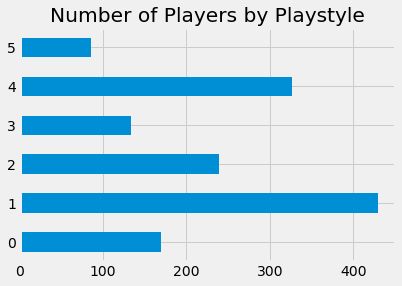

In [32]:
df['Class'].value_counts().sort_index().plot(kind='barh', title='Number of Players by Playstyle')

# Plotting

In [3]:
# RUN THIS TO USE PLOTTING FUNCTION

df = pd.read_csv('results2/fin_results2.csv')
df.Class.replace([10], [0], inplace=True)
classes = ['Ball-Dominant Scorer', 'Role Player', 'Stretch Big', 'Traditional Big', 'Secondary Guard', 
           'High-Usage Big']

df_2015 = df[df['Player'].str.contains('2015')]
df_2016 = df[df['Player'].str.contains('2016')]
df_2017 = df[df['Player'].str.contains('2017')]
df_2018 = df[df['Player'].str.contains('2018')]
df_2019 = df[df['Player'].str.contains('2019')]
df_2020 = df[df['Player'].str.contains('2020')]

df_2015.reset_index(drop=True, inplace=True)
df_2016.reset_index(drop=True, inplace=True)
df_2017.reset_index(drop=True, inplace=True)
df_2018.reset_index(drop=True, inplace=True)
df_2019.reset_index(drop=True, inplace=True)
df_2020.reset_index(drop=True, inplace=True)

Get data on each group (good/bad/average) for each year.

In [4]:
good_2015 = ['GSW', 'SAS', 'CLE', 'TOR', 'OKC', 'LAC', 'ATL', 'BOS']
bad_2015 = ['PHI', 'LAL', 'BKN', 'PHX', 'MIN', 'NOP', 'NYK', 'SAC']

good_2016 = ['GSW', 'SAS', 'HOU', 'BOS', 'CLE', 'LAC', 'TOR', 'UTA']
bad_2016 = ['BKN', 'PHX', 'LAL', 'PHI', 'ORL', 'NYK', 'MIN', 'SAC']

good_2017 = ['HOU', 'TOR', 'GSW', 'BOS', 'PHI', 'CLE', 'POR', 'IND']
bad_2017 = ['PHX', 'MEM', 'DAL', 'ATL', 'ORL', 'SAC', 'CHI', 'BKN']

good_2018 = ['MIL', 'TOR', 'GSW', 'DEN', 'HOU', 'POR', 'PHI','UTA']
bad_2018 = ['NYK', 'PHX', 'CLE', 'CHI', 'ATL', 'WAS', 'NOP', 'MEM']

good_2019 = ['MIL', 'TOR', 'LAL', 'LAC', 'BOS', 'DEN', 'IND', 'HOU']
bad_2019 = ['GSW', 'MIN', 'CLE', 'DET', 'ATL', 'NYK', 'CHI', 'CHA']

good_2020 = ['UTA', 'PHI', 'PHO', 'LAC', 'MIL', 'BKN', 'LAL', 'DEN']
bad_2020 = ['MIN', 'DET', 'ORL', 'HOU', 'WAS', 'CLE', 'TOR', 'OKC']

In [5]:
def get_good_bad_avg(df, year):
    if year > 0:
        # use get_teams to get good and bad teams for that year
        good_teams, bad_teams = get_teams(year)
        index=[0,1,2,3,4,5]
        df = df[df['Player'].str.contains(f'{year}')]
        top_5_df = pd.DataFrame(df.groupby('TEAM')['MIN'].nlargest()).reset_index()['level_1']
        temp = df.merge(top_5_df, left_index=True, right_on='level_1', how='inner').reset_index(drop=True)
        # get average number of playstyles for each type of team
        good_df = pd.DataFrame(temp[temp['TEAM'].isin(good_teams)]['Class'].value_counts().reindex(
                    index=index, fill_value=0).sort_index())
        good_df['Class'] = good_df['Class'] / 8

        bad_df = pd.DataFrame(temp[temp['TEAM'].isin(bad_teams)]['Class'].value_counts().reindex(
                    index=index, fill_value=0).sort_index())
        bad_df['Class'] = bad_df['Class'] / 8
    
        avg_df = pd.DataFrame(temp.drop(temp[temp['TEAM'].isin(good_teams + bad_teams)].index)['Class'].value_counts().reindex(
                    index=index, fill_value=0).sort_index())
        avg_df['Class'] = avg_df['Class'] / 14
    else:
        good_df, bad_df, avg_df = gba_all_years(df)
        
    return good_df, bad_df, avg_df

def get_teams(year):
    if year == 2015:
        good_teams = good_2015
        bad_teams = bad_2015
    elif year == 2016:
        good_teams = good_2016
        bad_teams = bad_2016
    elif year == 2017:
        good_teams = good_2017
        bad_teams = bad_2017
    elif year == 2018:
        good_teams = good_2018
        bad_teams = bad_2018
    elif year == 2019:
        good_teams = good_2019
        bad_teams = bad_2019
    elif year == 2020:
        good_teams = good_2020
        bad_teams = bad_2020
    else:
        return "Please enter a year between 2015 and 2020, inclusive"
    return good_teams, bad_teams

def gba_all_years(df):
    top_5_df = pd.DataFrame(df.groupby('TEAM')['MIN'].nlargest()).reset_index()['level_1']
    temp = df.merge(top_5_df, left_index=True, right_on='level_1', how='inner').reset_index(drop=True)
    good_df, bad_df, avg_df = get_good_bad_avg(temp, 2015)  

    for df, year in zip([df_2016,df_2017,df_2018,df_2019,df_2020],[2016,2017,2018,2019,2020]):
            
        top_5_df = pd.DataFrame(df.groupby('TEAM')['MIN'].nlargest()).reset_index()['level_1']
        temp2 = df.merge(top_5_df, left_index=True, right_on='level_1', how='inner').reset_index(drop=True)
        
        good_df_temp, bad_df_temp, avg_df_temp = get_good_bad_avg(temp2, year)
        
        good_df['Class'] += good_df_temp['Class']
        bad_df['Class'] += bad_df_temp['Class']
        avg_df['Class'] += avg_df_temp['Class']
            
    good_df['Class'] = good_df['Class'] / 6
    bad_df['Class'] = bad_df['Class'] / 6
    avg_df['Class'] = avg_df['Class'] / 6
        
    return good_df, bad_df, avg_df

In [6]:
g,b,a=get_good_bad_avg(df_2015,2015)
g

,Class
0,1.125
1,0.875
2,0.750
3,0.625
4,1.125
5,0.500


In [38]:
g, b, a = gba_all_years(df)
b

,Class
0,0.666667
1,0.645833
2,0.937500
3,0.229167
4,1.395833
5,0.437500


In [7]:
# %load radar_plotting.py
import pandas as pd
import plotly.graph_objects as go

# This function creates radar plots. Classes refers to a list that contains the names of each player class,
# year refers to the season you want to look at and good/bad/average give you the option of which teams you want
# shown on the radar plot

def plot_radar(classes, years=[2015,2016,2017,2018,2019,2020], good=True, bad=True, average=False, semisup=True):
        
    model = ''
    if semisup == True:
        model = 'Semi-Supervised'
    else:
        model = 'Unsupervised'
        
    fig = go.Figure()
    # if all years selected
    if years == 0:
        good_df, bad_df, avg_df = gba_all_years(df)
    else:
        # get good/bad/avg for first year selected
        good_df, bad_df, avg_df = get_good_bad_avg(df, years[0])
        
        # get good/bad/avg for the rest of the years, if more than one selected 
        if len(years) > 1:
            for year in years[1:]:
                # get yearly stats
                temp_df = df[df['Player'].str.contains(f'{year}')]
                # get good/bad/avg for that year
                temp_g, temp_b, temp_a = get_good_bad_avg(temp_df, year)
                good_df += temp_g; bad_df += temp_b; avg_df += temp_a
            good_df = good_df / len(years); bad_df = bad_df / len(years); avg_df = avg_df / len(years)

    if good:
        fig.add_trace(go.Scatterpolar(
            r=good_df['Class'],
            theta=classes,
              fill='toself',
              name='Good Teams'
        ))
    if bad:
        fig.add_trace(go.Scatterpolar(
            r=bad_df['Class'],
            theta=classes,
              fill='toself',
              name='Bad Teams'
        ))
    if average:
        fig.add_trace(go.Scatterpolar(
            r=avg_df['Class'],
            theta=classes,
              fill='toself',
              name='Average Teams'
        ))
            
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
              visible=True
        )),
    showlegend=True,
    title=f"{years} NBA Team Composition: {model} Model"
    )
    fig.show()

In [12]:
plot_radar(classes, [0])

In [33]:
plot_radar(classes, [0], average=True)

In [15]:
plot_radar(classes, [2019])